# Investigating the Impacts of Urban Expansion in Phoenix, AZ
## Assessing Changes in the Biodiversity Intactness Index (BII) from 2017 to 2020
### Author: Carmen Hoyt
### [GitHub Repository](https://github.com/ceh58/biodiversity-phoenix)

### About
- Purpose
- Highlights
- Data

1. Biodiversity Intactness Index (BII) Time Series
- References

### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from the MPC STAC catalog

from IPython.display import Image # To nicely display images

## Import Phoenix county shapefile
[TIGER/Line](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions)

<Axes: >

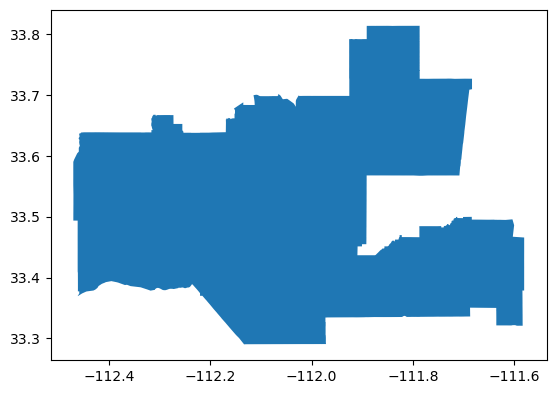

In [2]:
counties = gpd.read_file(os.path.join("data/",
                  'tl_2020_04_cousub.shp'))

counties.rename(columns=str.lower, inplace=True)

phoenix = counties.loc[(counties['name'] == "Phoenix")]

# Examine phoenix data
phoenix.crs
phoenix.plot()

### Access
We use the `Client` function from the `pystac_client` package to access the catalog:

In [3]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Explore catalog metadata
print('Title: ', catalog.title)
print('Description: ', catalog.description)

Title:  Microsoft Planetary Computer STAC API
Description:  Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


We can access its collections by using the `get_collections()` method:

In [5]:
# Get collections and print their names
collections = list(catalog.get_collections()) # Turn the generator into a list

print('Number of collections ', len(collections))

print('Collection IDs (first 10): ')
for i in range(10):
    print('-', collections[i].id)

Number of collections  124
Collection IDs (first 10): 
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


We are interested in the `io-biodiversity` collection. To find data for Phoenix, AZ, we will need to specify a bounding box.

In [6]:
# Specify bounding box for Phoenix, AZ
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search catalog using the bbox
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest)

# Print all of the items returned in the search
items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


Our search returned 4 items, data for each year from 2017 to 2020. 

In [7]:
# Get first item (2020 data) in the catalog search
item_2020 = items[0]
item_2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [8]:
# Print item ID and properties
print('ID: ', item_2020.id)
item_2020.properties

# Explore item assets
for key in item_2020.assets.keys():
    print(key, "--", item_2020.assets[key].title)

ID:  bii_2020_34.74464974521749_-115.38597824385106_cog
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


## Load data

The raster data in our current `item` is the `data` asset.
Again, we access this data via its URL.
This time we open it using `rioxr.open_rasterio()` and save it as `phoenix_2020`, since it is the 2020 data.

In [9]:
# Access and save 2020 raster data
phoenix_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
phoenix_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
# Preliminary exploration
print('Sizes of dimensions:', dict(phoenix_2020.sizes))
print('attrs:', phoenix_2020.attrs)
print(phoenix_2020.dims, phoenix_2020.coords)

Sizes of dimensions: {'band': 1, 'y': 7992, 'x': 7992}
attrs: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


The dimension 'band' of size 1 is not useful. We can drop it using the `squeeze()` and `.drop_vars()`functions.

In [11]:
# Drop the 'band' dimension
phoenix_2020 = phoenix_2020.squeeze().drop_vars('band')

In [12]:
# Confirm 'band' was dropped
print(phoenix_2020.dims, phoenix_2020.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


Now we will do the same for the 2017 data.

In [13]:
# Get third item (2017 data) in the catalog search
item_2017 = items[3]
item_2017

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

In [14]:
# Access and save 2017 raster data
phoenix_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
phoenix_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [15]:
# Drop the 'band' dimension
phoenix_2017 = phoenix_2017.squeeze().drop_vars('band')

# Confirm 'band' was dropped
print(phoenix_2017.dims, phoenix_2017.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


# Match CRSs and verify update

In [16]:
# Match CRSs and verify update
phoenix_match = phoenix.to_crs(phoenix_2020.rio.crs)
assert phoenix_match.crs == phoenix_2020.rio.crs

In [17]:
print('Original 2020 no-data value:', phoenix_2020.rio.nodata)

# Update 2020 raster's no-data value
phoenix_2020 = phoenix_2020.rio.write_nodata(0)
print('Updated 2020 no-data value:', phoenix_2020.rio.nodata)

Original 2020 no-data value: None
Updated 2020 no-data value: 0.0


In [18]:
# and 2017 raster's no-data value
print('Original 2017 no-data value:', phoenix_2017.rio.nodata)

# Update 2020 raster's no-data value
phoenix_2017 = phoenix_2017.rio.write_nodata(0)
print('Updated 2017 no-data value:', phoenix_2017.rio.nodata)

Original 2017 no-data value: None
Updated 2017 no-data value: 0.0


In [19]:
# Clip the 2020 raster to detailed geometry
phoenix_2020_clip = (phoenix_2020.rio.clip_box(*phoenix_match.total_bounds)
                .rio.clip(phoenix_match.geometry))

# Clip the 2017 raster to detailed geometry
phoenix_2017_clip = (phoenix_2017.rio.clip_box(*phoenix_match.total_bounds)
                .rio.clip(phoenix_match.geometry))

In [20]:
# Filter for BII >= 0.75
BII_75_2020 = phoenix_2020_clip >= 0.75

# Count pixels for True/False
values, counts = np.unique(BII_75_2020, return_counts = True)

In [21]:
# Create a dataframe
d = {'values': values, 'counts': counts}
pix_counts_2020 = pd.DataFrame(data=d)
pix_counts_2020.head()

,values,counts
0,False,555184
1,True,21986


In [22]:
# Calculate total pixels
total_pixels = sum(pix_counts_2020['counts'])
print(f"The total number of pixels within the Phoenix border is {sum(pix_counts_2020['counts'])}.")

The total number of pixels within the Phoenix border is 577170.


In [23]:
# Find percentage
pix_counts_2020['percentage'] = (pix_counts_2020['counts']/total_pixels) *100
pix_counts_2020.sort_values(by = 'percentage', ascending = False)
pix_counts_2020.head()

,values,counts,percentage
0,False,555184,96.190724
1,True,21986,3.809276


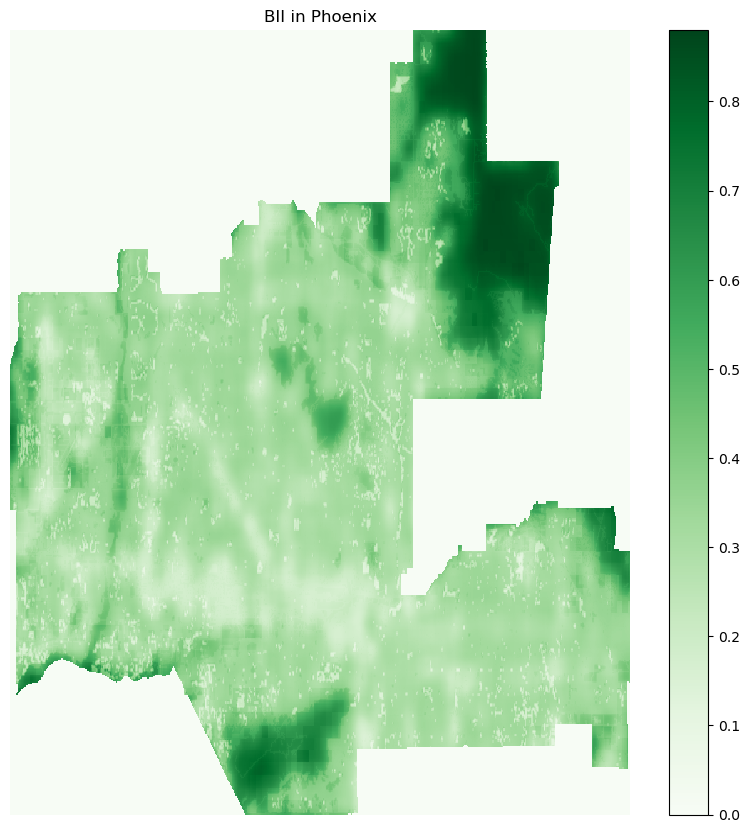

In [25]:
aspect = phoenix_2020_clip.rio.width/phoenix_2020_clip.rio.height

fig, ax = plt.subplots(figsize = (10, 6*aspect))

# Plot the first clipped raster
phoenix_2020_clip.plot(ax=ax, cmap="Greens")
ax.set_title("BII in Phoenix")
ax.axis("off")

plt.show()